## Machine Learning Classification Pipeline

This code sets up a comprehensive machine learning environment for classification tasks. It imports essential libraries for:

**Data Processing & Analysis:**
- `pandas` and `numpy` for data manipulation
- `matplotlib` and `seaborn` for visualization
- `collections.Counter` for data counting operations

**Machine Learning Pipeline:**
- **Preprocessing:** StandardScaler, LabelEncoder, SimpleImputer for data preparation
- **Model Selection:** train_test_split, cross-validation, and hyperparameter tuning tools
- **Classifiers:** Multiple algorithms including Logistic Regression, Random Forest, Gradient Boosting, SVM, KNN, and Decision Tree
- **Evaluation:** Comprehensive metrics (accuracy, ROC-AUC, F1-score, confusion matrix, classification reports)
- **Pipeline Tools:** Pipeline and ColumnTransformer for streamlined workflows

**Advanced Features:**
- **Class Imbalance:** SMOTE oversampling and imbalanced-learn pipeline
- **Optional XGBoost:** Graceful handling of XGBoost import with fallback if unavailable

The setup suggests a robust classification workflow with proper data preprocessing, multiple model comparison, hyperparameter optimization, and comprehensive evaluation metrics.

In [11]:
# import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# try to import XGBoost
try:
    from xgboost import XGBClassifier
    xgboost_available = True
except ImportError:
    xgboost_available = False
    print("XGBoost not available. Continuing without it...")


## Data Loading and Preprocessing

This code performs comprehensive data cleaning and balancing for a heart disease classification dataset:

**Training Data Processing:**
- Loads heart disease training data from `heart_2020_cleaned.csv`
- **Class Balancing:** Creates a balanced dataset by:
  - Identifying minority class count (HeartDisease = 'Yes')
  - Sampling equal numbers from both classes to eliminate class imbalance
  - Shuffling the balanced sample for randomization
- Displays dataset shape and class distribution before/after balancing

**Test Data Processing:**
- Loads test data from `heart_2022_with_nans.csv` with error handling for malformed lines
- **Column Standardization:** Renames test data columns to match training data format:
  - `SmokerStatus` → `Smoking`
  - `AlcoholDrinkers` → `AlcoholDrinking`
  - `HadStroke` → `Stroke`
  - And several other medical/demographic feature mappings
- **Schema Alignment:** Removes columns from test data that don't exist in training data
- Saves the cleaned test data as `heart_2022_with_nans_cleaned.csv`

**Key Features:**
- Handles class imbalance through undersampling
- Ensures train/test schema consistency
- Robust error handling for data loading
- Preserves data integrity with random state seedingRetryClaude does not have the ability to run the code it generates yet.

In [12]:
# clean data set
# read training data
df = pd.read_csv("heart_2020_cleaned.csv")
print("Training data loaded:")
print(df.head())
print(f"Training data shape: {df.shape}")
# Identify the minority class count
minority_class_count = df['HeartDisease'].value_counts()['Yes']

# Sample a fixed number from each class to create a balanced sample
df_yes = df[df['HeartDisease'] == 'Yes'].sample(minority_class_count, random_state=42)
df_no = df[df['HeartDisease'] == 'No'].sample(minority_class_count, random_state=42)

# Concatenate the balanced samples
df_balanced_sample = pd.concat([df_yes, df_no])

# Shuffle the balanced sample (optional but recommended)
df = df_balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)

print("Original dataset shape:", df.shape)
print("Balanced sample shape:", df_balanced_sample.shape)
print("HeartDisease distribution in balanced sample:")
display(df['HeartDisease'].value_counts())

# read test data
df_test = pd.read_csv("heart_2022_with_nans.csv", on_bad_lines="skip")
print("\nTest data loaded:")
print(df_test.head())
print(f"Test data shape: {df_test.shape}")

# rename columns in df_test
df_test = df_test.rename(columns={
    'SmokerStatus': 'Smoking',
    'AlcoholDrinkers': 'AlcoholDrinking',
    'HadStroke': 'Stroke',
    'PhysicalHealthDays': 'PhysicalHealth',
    'MentalHealthDays': 'MentalHealth',
    'DifficultyWalking': 'DiffWalking',
    'RaceEthnicityCategory': 'Race',
    'HadDiabetes': 'Diabetic',
    'PhysicalActivities': 'PhysicalActivity',
    'GeneralHealth': 'GenHealth',
    'SleepHours': 'SleepTime',
    'HadAsthma': 'Asthma',
    'HadKidneyDisease': 'KidneyDisease',
    'HadSkinCancer': 'SkinCancer'
})

# drop columns in df_test that are not in df
df_test = df_test.drop(columns=[col for col in df_test.columns if col not in df.columns])
print("Updated test data columns:")
print(list(df_test.columns))

# save cleaned test data
df_test.to_csv("heart_2022_with_nans_cleaned.csv", index=False)
print("Cleaned test data saved.")

Training data loaded:
  HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No             3.0   
1           No  20.34      No              No    Yes             0.0   
2           No  26.58     Yes              No     No            20.0   
3           No  24.21      No              No     No             0.0   
4           No  23.71      No              No     No            28.0   

   MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0          30.0          No  Female        55-59  White      Yes   
1           0.0          No  Female  80 or older  White       No   
2          30.0          No    Male        65-69  White      Yes   
3           0.0          No  Female        75-79  White       No   
4           0.0         Yes  Female        40-44  White       No   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
0              Yes  Very good        5.0    Yes            No

HeartDisease
Yes    27373
No     27373
Name: count, dtype: int64


Test data loaded:
     State     Sex GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
0  Alabama  Female     Very good                 0.0               0.0   
1  Alabama  Female     Excellent                 0.0               0.0   
2  Alabama  Female     Very good                 2.0               3.0   
3  Alabama  Female     Excellent                 0.0               0.0   
4  Alabama  Female          Fair                 2.0               0.0   

                                     LastCheckupTime PhysicalActivities  \
0  Within past year (anytime less than 12 months ...                 No   
1                                                NaN                 No   
2  Within past year (anytime less than 12 months ...                Yes   
3  Within past year (anytime less than 12 months ...                Yes   
4  Within past year (anytime less than 12 months ...                Yes   

   SleepHours RemovedTeeth HadHeartAttack  ... HeightInMeters  \
0         8.0       

## Exploratory Data Analysis (EDA)

This code performs comprehensive exploratory data analysis on the cleaned test dataset:

**Data Loading:**
- Loads the preprocessed test dataset (`heart_2022_with_nans_cleaned.csv`)
- Automatically identifies numeric columns using pandas data type detection

**Distribution Analysis:**
- **Histograms with KDE:** Creates individual distribution plots for each numeric feature
  - Uses 30 bins with kernel density estimation overlay
  - Dynamically adjusts subplot layout based on number of numeric columns
  - Handles single-column edge case with proper axis formatting

**Correlation Analysis:**
- **Correlation Matrix:** Computes pairwise correlations between all numeric features
- **Heatmap Visualization:** Creates an annotated correlation heatmap
  - Uses 'coolwarm' colormap for intuitive interpretation
  - Displays correlation coefficients with 2 decimal precision
  - Includes color bar for reference

**Outlier Detection:**
- **Box Plots:** Creates side-by-side box plots for all numeric columns
  - Helps identify outliers, quartiles, and data spread
  - Rotated x-axis labels for readability

**Key Features:**
- Robust handling of datasets with varying numbers of numeric columns
- Professional visualization styling with proper titles and formatting
- Comprehensive statistical overview of the test dataset's numeric features

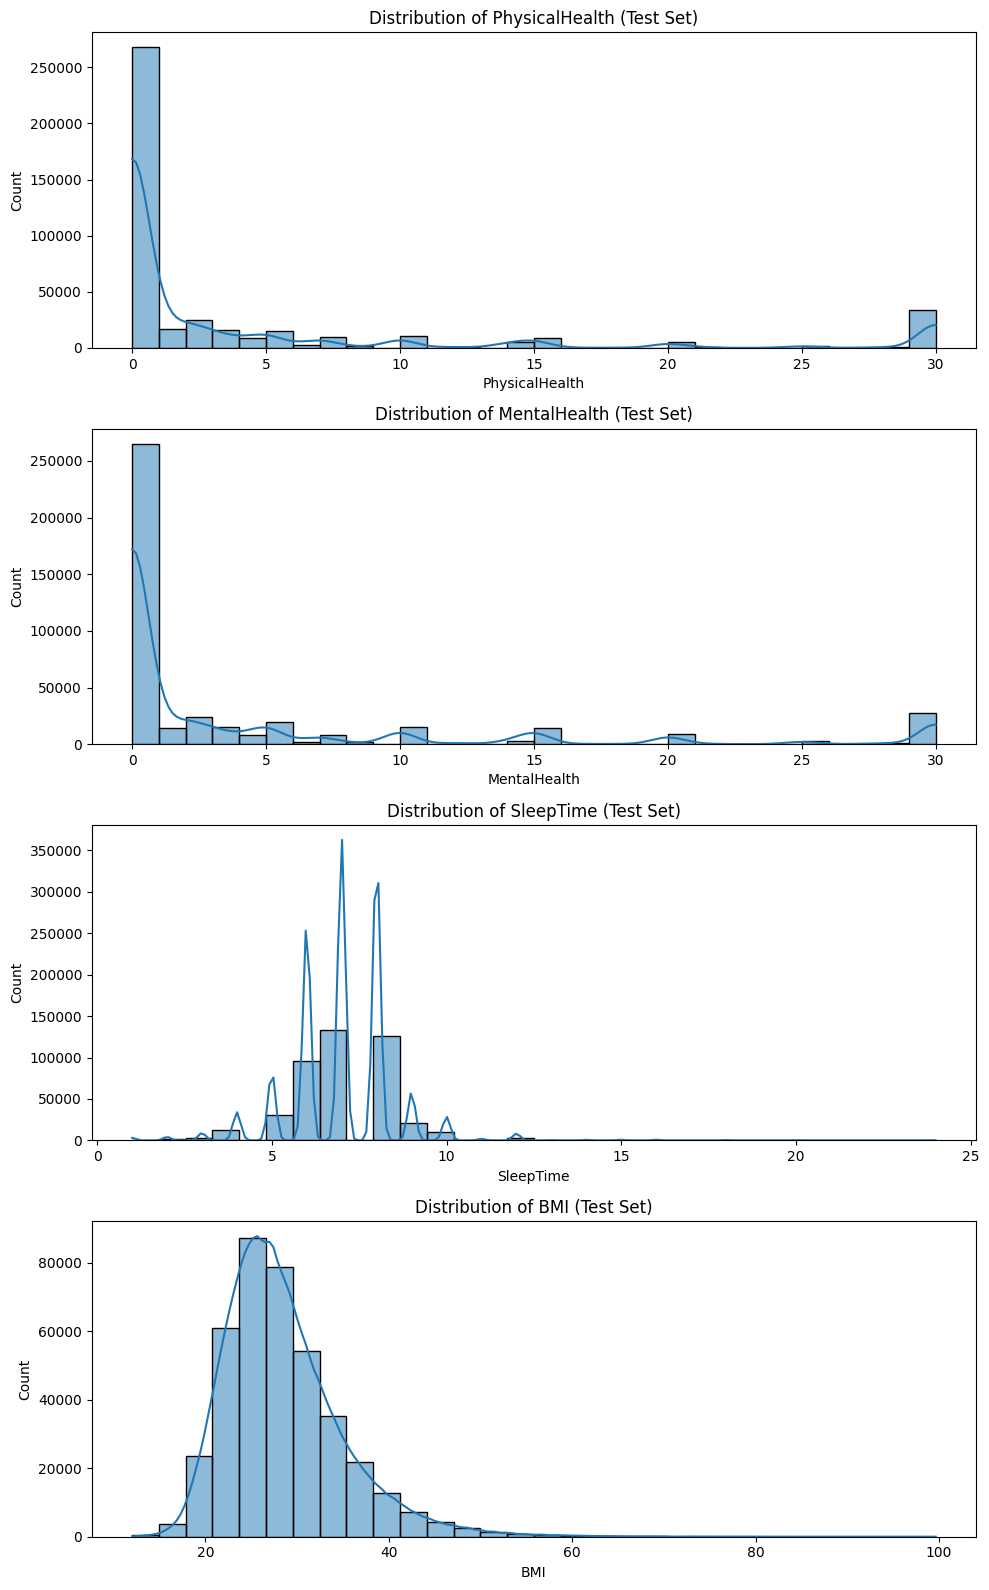

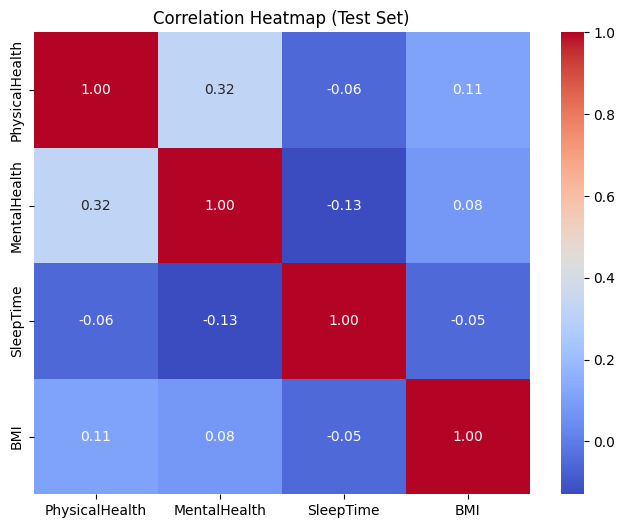

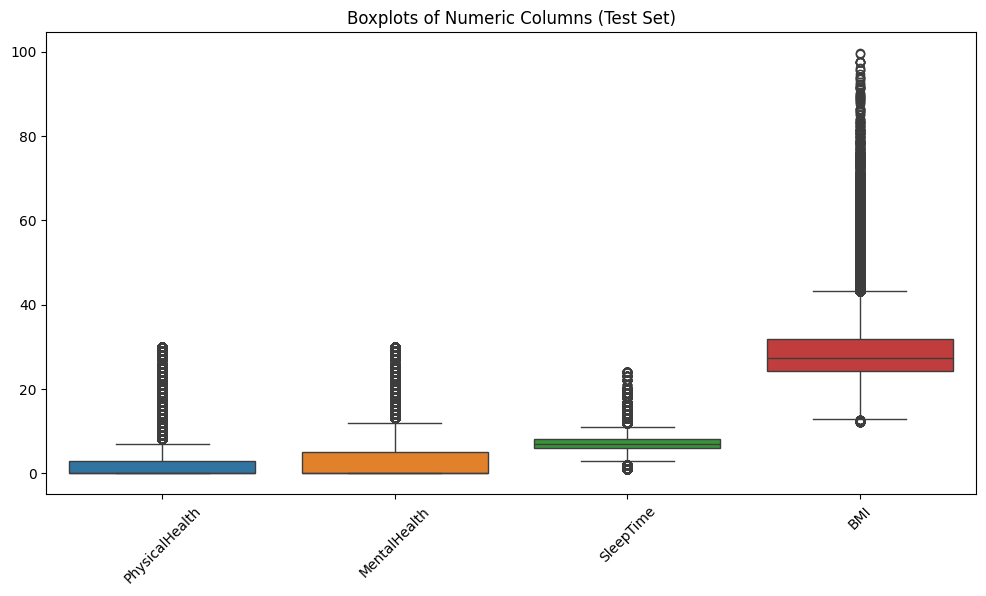

In [13]:
# EDA
# load cleaned test dataset for EDA
df_test = pd.read_csv('heart_2022_with_nans_cleaned.csv')

# define numeric columns
numeric_cols_test = df_test.select_dtypes(include=np.number).columns.tolist()

# create histograms if we have numeric columns
if len(numeric_cols_test) > 0:
    fig, axes = plt.subplots(nrows=len(numeric_cols_test), figsize=(10, 4 * len(numeric_cols_test)))
    if len(numeric_cols_test) == 1:
        axes = [axes]

    for ax, col in zip(axes, numeric_cols_test):
        sns.histplot(df_test[col], kde=True, ax=ax, bins=30)
        ax.set_title(f'Distribution of {col} (Test Set)')
    plt.tight_layout()
    plt.show()

    # correlation matrix
    corr_matrix_test = df_test[numeric_cols_test].corr()

    # correlation heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix_test, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
    plt.title('Correlation Heatmap (Test Set)')
    plt.show()

    # boxplots
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_test[numeric_cols_test])
    plt.title('Boxplots of Numeric Columns (Test Set)')
    plt.xticks(rotation=45)
    plt.show()


## Data Preprocessing and Feature Engineering

This code performs comprehensive data preparation for machine learning modeling:

**Feature Identification:**
- Automatically separates numeric and categorical columns from training data
- Identifies target variable (`HeartDisease`) and removes it from feature lists
- Displays column distributions and target class balance

**Missing Value Imputation:**
- **Numeric Features:** Uses median imputation strategy
- **Categorical Features:** Uses most frequent value imputation
- Fits imputers on training data and applies to both train/test sets to prevent data leakage

**Categorical Encoding:**
- **One-Hot Encoding:** Converts categorical variables to binary features
- Uses `drop_first=True` to avoid multicollinearity
- Applies consistent encoding to both training and test datasets

**Target Variable Processing:**
- **Label Encoding:** Converts target categories to numeric labels
- Displays class mappings for interpretability

**Feature Alignment:**
- **Schema Consistency:** Ensures test data has same columns as training data
- Adds missing columns with zero values
- Reorders test columns to match training data structure

**Data Cleaning:**
- **Remaining NaNs:** Fills any residual missing values with column means
- Ensures no missing data in final datasets

**Feature Scaling:**
- **StandardScaler:** Standardizes numeric features to zero mean, unit variance
- Fits scaler on training data only to prevent data leakage
- Applies same transformation to test data

**Train-Validation Split:**
- Creates 80-20 train-validation split with stratification
- Maintains class distribution balance across splits
- Uses fixed random state for reproducibility

**Key Features:**
- Prevents data leakage through proper fit-transform workflow
- Handles schema mismatches between train/test data
- Comprehensive preprocessing pipeline ready for model training

In [14]:
# prepare data for modeling
# identify numeric and categorical columns from training data
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# define target variable
target_col = 'HeartDisease'
print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)
print("Target column:", target_col)

# remove target column from feature lists
if target_col in numeric_cols:
    numeric_cols.remove(target_col)
if target_col in categorical_cols:
    categorical_cols.remove(target_col)

print(f"\nFeature columns after removing target:")
print(f"Numeric: {numeric_cols}")
print(f"Categorical: {categorical_cols}")

# check target distribution
if target_col in df.columns:
    print(f"\nTarget distribution:")
    print(df[target_col].value_counts())

# impute missing values
# create separate imputers for training data
numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# fit on training data and transform both training and test
if len(numeric_cols) > 0:
    df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])
    df_test[numeric_cols] = numeric_imputer.transform(df_test[numeric_cols])
    print("Numeric missing values imputed with median")

if len(categorical_cols) > 0:
    df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])
    df_test[categorical_cols] = categorical_imputer.transform(df_test[categorical_cols])
    print("Categorical missing values imputed with most frequent")
print("\nEncoding categorical variables...")

# one-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df_test_encoded = pd.get_dummies(df_test, columns=categorical_cols, drop_first=True)
print(f"After encoding - Training shape: {df_encoded.shape}")
print(f"After encoding - Test shape: {df_test_encoded.shape}")

# prepare features and target
# separate features and target
X = df_encoded.drop(target_col, axis=1)
y = df_encoded[target_col]

# encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Target classes: {le.classes_}")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y_encoded.shape}")

# align test data with training data
# make sure test data has same columns as training data
missing_cols = set(X.columns) - set(df_test_encoded.columns)
for c in missing_cols:
    df_test_encoded[c] = 0

# reorder columns to match training data
df_test_encoded = df_test_encoded[X.columns]
print(f"Test data aligned. Shape: {df_test_encoded.shape}")

# handle remaining missing values
# fill any remaining NaN values
X = X.fillna(X.mean())
df_test_encoded = df_test_encoded.fillna(X.mean())
print("Remaining missing values handled")

# scale numeric features
# get numeric columns after encoding
numeric_cols_encoded = X.select_dtypes(include=['number']).columns.tolist()

# scale numeric features
scaler = StandardScaler()
X[numeric_cols_encoded] = scaler.fit_transform(X[numeric_cols_encoded])
df_test_encoded[numeric_cols_encoded] = scaler.transform(df_test_encoded[numeric_cols_encoded])
print(f"Scaled {len(numeric_cols_encoded)} numeric features")

# train-test split
# train-validation split (80-20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

Numeric columns: ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
Categorical columns: ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']
Target column: HeartDisease

Feature columns after removing target:
Numeric: ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
Categorical: ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']

Target distribution:
HeartDisease
Yes    27373
No     27373
Name: count, dtype: int64
Numeric missing values imputed with median
Categorical missing values imputed with most frequent

Encoding categorical variables...
After encoding - Training shape: (54746, 38)
After encoding - Test shape: (445132, 41)
Target classes: ['No' 'Yes']
Features shape: (54746, 37)
Target shape: (54746,)
Test data aligne

## Model Definition and Evaluation Pipeline

This code establishes a comprehensive machine learning model comparison framework:

**Model Portfolio:**
- **Core Models:** Defines 5 classification algorithms with optimized parameters:
  - Logistic Regression (max_iter=1000 for convergence)
  - Random Forest (100 estimators)
  - Gradient Boosting (100 estimators)
  - K-Nearest Neighbors (default parameters)
  - Decision Tree (basic configuration)
- **Conditional XGBoost:** Adds XGBoost if library is available, with logloss evaluation metric

**Cross-Validation Framework:**
- **Stratified K-Fold:** Uses 5-fold cross-validation with stratification
- Maintains class distribution balance across folds
- Shuffles data with fixed random state for reproducibility

**Advanced Pipeline Architecture:**
- **SMOTE Integration:** Each model wrapped in pipeline with SMOTE oversampling
- Addresses class imbalance by generating synthetic minority class samples
- Prevents data leakage by applying SMOTE within CV folds

**Multi-Metric Evaluation:**
- **F1-Macro Score:** Primary metric for balanced performance across classes
- **Accuracy:** Overall classification correctness
- **ROC-AUC:** Area under the receiver operating characteristic curve
- Parallel processing (`n_jobs=-1`) for faster computation

**Results Analysis:**
- Comprehensive performance reporting with mean scores and standard deviations
- Statistical significance through cross-validation variance
- Stores all metrics for comparative analysis

**Best Model Selection:**
- **F1-Macro Optimization:** Selects best performing model based on F1-macro score
- Prioritizes balanced performance over pure accuracy
- Ideal for imbalanced classification problems

**Key Features:**
- Robust evaluation preventing overfitting through proper CV
- Handles class imbalance with SMOTE
- Comprehensive metric suite for thorough model assessment

In [15]:
# define models
# create dictionary of models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
}

# add XGBoost if available
if xgboost_available:
    models['XGBoost'] = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
print(f"Defined {len(models)} models")

# cross validation and model evalutation
# set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}
print("\nModel Evaluation Results:")
print("-" * 50)

# evaluate each model
for name, model in models.items():
    print(f"Evaluating {name}...")

    # create pipeline with SMOTE
    pipeline = ImbPipeline(steps=[
        ("smote", SMOTE(random_state=42)),
        ("classifier", model)
    ])

    # calculate multiple metrics
    f1_scores = cross_val_score(pipeline, X, y_encoded, cv=cv, scoring="f1_macro", n_jobs=-1)
    accuracy_scores = cross_val_score(pipeline, X, y_encoded, cv=cv, scoring="accuracy", n_jobs=-1)
    roc_scores = cross_val_score(pipeline, X, y_encoded, cv=cv, scoring="roc_auc", n_jobs=-1)

    # store results
    results[name] = {
        'f1_macro': f1_scores.mean(),
        'accuracy': accuracy_scores.mean(),
        'roc_auc': roc_scores.mean()
    }
    print(f"  F1-Macro: {f1_scores.mean():.4f} (+/- {f1_scores.std():.4f})")
    print(f"  Accuracy: {accuracy_scores.mean():.4f} (+/- {accuracy_scores.std():.4f})")
    print(f"  ROC-AUC:  {roc_scores.mean():.4f} (+/- {roc_scores.std():.4f})")
    print()

# select best model
# choose best model based on F1-macro score
best_model_name = max(results, key=lambda x: results[x]['f1_macro'])
best_model = models[best_model_name]
print(f"Best model: {best_model_name}")
print(f"Best F1-Macro score: {results[best_model_name]['f1_macro']:.4f}")

Defined 6 models

Model Evaluation Results:
--------------------------------------------------
Evaluating Logistic Regression...


KeyboardInterrupt: 

## Hyperparameter Optimization

This code implements automated hyperparameter tuning for the best performing model:

**Parameter Search Spaces:**
- **Logistic Regression:** Regularization strength (C), penalty type (L1/L2), solver compatibility
- **Random Forest:** Number of estimators (50-200), tree depth (3, 5, unlimited)
- **Gradient Boosting:** Estimators (50-200), learning rate (0.1-0.2)
- **K-Nearest Neighbors:** Number of neighbors (3-9)
- **Decision Tree:** Maximum depth (3, 5, 10, unlimited)
- **XGBoost:** Estimators and learning rate (conditional on availability)

**Pipeline Architecture:**
- **SMOTE Integration:** Maintains SMOTE oversampling in tuning pipeline
- **Classifier Prefix:** Uses `classifier__` prefix for pipeline parameter access
- Ensures consistent data preprocessing during hyperparameter search

**Optimization Strategy:**
- **RandomizedSearchCV:** Efficient parameter exploration with 10 iterations
- **F1-Macro Optimization:** Primary scoring metric for balanced performance
- **3-Fold Cross-Validation:** Faster tuning with reasonable validation
- **Parallel Processing:** Utilizes all CPU cores for accelerated search

**Adaptive Training:**
- **Conditional Tuning:** Only tunes if parameter grid exists for the best model
- **Fallback Training:** Uses default parameters if no tuning grid defined
- **Best Estimator Selection:** Automatically selects optimal hyperparameters

**Results Reporting:**
- **Best Parameters:** Displays optimal hyperparameter combination
- **Cross-Validation Score:** Shows tuned model's F1-macro performance
- **Transparency:** Clear indication of tuning status and methodology

**Key Features:**
- Computationally efficient with randomized search
- Maintains pipeline integrity with SMOTE
- Robust fallback for models without defined parameter grids
- Optimizes for imbalanced classification performance

In [ ]:
# tune hyperparamters
# simple hyperparameter tuning for best model
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [3, 5, None]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.1, 0.2]
    },
    'K-Nearest Neighbors': {
        'classifier__n_neighbors': [3, 5, 7, 9]
    },
    'Decision Tree': {
        'classifier__max_depth': [3, 5, 10, None]
    }
}

if xgboost_available:
    param_grids['XGBoost'] = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.1, 0.2]
    }

# create pipeline for best model
pipeline = ImbPipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("classifier", best_model)
])

# perform hyperparameter tuning if parameters are defined
if best_model_name in param_grids:
    print(f"Tuning hyperparameters for {best_model_name}...")

    grid_search = RandomizedSearchCV(
        pipeline,
        param_grids[best_model_name],
        n_iter=10,
        cv=3,
        scoring='f1_macro',
        random_state=42,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    pipeline = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
else:
    print("No hyperparameter tuning defined for this model, using default parameters")
    pipeline.fit(X_train, y_train)

Tuning hyperparameters for Logistic Regression...


c:\Users\tyler\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__C': 0.1}
Best CV score: 0.7658


## Final Model Validation and Performance Assessment

This code conducts comprehensive evaluation of the optimized model on the validation set:

**Prediction Generation:**
- **Binary Predictions:** Uses `predict()` for hard classifications
- **Probability Scores:** Uses `predict_proba()` for confidence scores and ROC analysis
- Applies tuned pipeline (with SMOTE) to unseen validation data

**Performance Metrics:**
- **Accuracy:** Overall classification correctness across all classes
- **F1-Macro:** Balanced performance metric averaging F1 scores per class
- **ROC-AUC:** Area under curve measuring discrimination ability using probability scores
- Provides comprehensive view of model performance

**Detailed Analysis:**
- **Classification Report:** Per-class precision, recall, F1-score, and support
- **Target Name Mapping:** Uses original class labels from LabelEncoder for interpretability
- Shows performance breakdown for each heart disease category

**Confusion Matrix:**
- **Raw Numbers:** Displays actual vs predicted classification counts
- **Visual Heatmap:** Color-coded confusion matrix with:
  - Blue color scheme for professional appearance
  - Annotated cell values for exact counts
  - Proper axis labels with original class names
  - Clear title and axis descriptions

**Model Interpretability:**
- **True vs Predicted Labels:** Easy identification of classification errors
- **Class-Specific Performance:** Reveals which classes are harder to predict
- **Bias Detection:** Shows if model favors certain classifications

**Key Features:**
- Comprehensive metric suite for thorough evaluation
- Professional visualization for stakeholder communication
- Maintains label interpretability with original class names
- Provides both quantitative metrics and qualitative insights
- Final validation on truly unseen data (no data leakage)

Final Validation Results:
Accuracy: 0.7573
F1-Macro: 0.7572
ROC-AUC: 0.8350

Classification Report:
              precision    recall  f1-score   support

          No       0.76      0.74      0.75      5475
         Yes       0.75      0.77      0.76      5475

    accuracy                           0.76     10950
   macro avg       0.76      0.76      0.76     10950
weighted avg       0.76      0.76      0.76     10950


Confusion Matrix:
[[4074 1401]
 [1257 4218]]


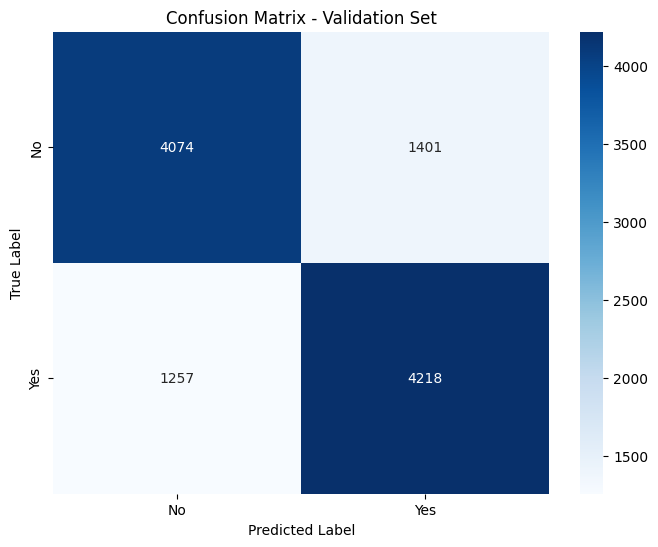

In [ ]:
# final validation
# make predictions on validation set
y_val_pred = pipeline.predict(X_val)
y_val_prob = pipeline.predict_proba(X_val)[:, 1]

# calculate final metrics
final_accuracy = accuracy_score(y_val, y_val_pred)
final_f1 = f1_score(y_val, y_val_pred, average='macro')
final_roc = roc_auc_score(y_val, y_val_prob)
print(f"Final Validation Results:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"F1-Macro: {final_f1:.4f}")
print(f"ROC-AUC: {final_roc:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_val, y_val_pred)
print(cm)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Test Set Prediction and Export

This code applies the trained and optimized model to make final predictions on the test dataset:

**Prediction Generation:**
- **Binary Classifications:** Uses `predict()` to generate hard class predictions
- **Confidence Scores:** Uses `predict_proba()` to extract probability scores for positive class
- Applies complete pipeline (SMOTE + tuned classifier) to preprocessed test data

**Label Transformation:**
- **Inverse Encoding:** Converts numeric predictions back to original string labels
- **Interpretability:** Uses LabelEncoder's `inverse_transform()` for human-readable results
- Maintains consistency with original data format

**Results Integration:**
- **Prediction Column:** Adds `HeartDisease` column with predicted classifications
- **Probability Column:** Adds `HeartDisease_Probability` with confidence scores (0-1 range)
- Enriches original test dataframe with model outputs

**Data Export:**
- **CSV Output:** Saves complete results to `heart_2022_with_predictions.csv`
- **Index Exclusion:** Removes pandas index for clean output file
- **Stakeholder Ready:** Creates deliverable dataset with predictions and confidence scores

**Key Features:**
- Maintains original test data structure with added predictions
- Provides both categorical predictions and numerical confidence
- Ready for business use with interpretable labels
- Complete audit trail with probability scores for decision transparency
- Seamless integration of ML results with original dataset

In [ ]:
# predict on test data
# make predictions on test set
test_predictions = pipeline.predict(df_test_encoded)
test_probabilities = pipeline.predict_proba(df_test_encoded)[:, 1]

# convert predictions back to original labels
test_predictions_labels = le.inverse_transform(test_predictions)

# add predictions to test dataframe
df_test["HeartDisease"] = test_predictions_labels
df_test["HeartDisease_Probability"] = test_probabilities

# save results
df_test.to_csv("heart_2022_with_predictions.csv", index=False)

## Prediction Summary and Results Overview

This code provides a comprehensive summary of the model's predictions on the test dataset:

**Prediction Statistics:**
- **Total Count:** Reports the complete number of predictions made on test data
- **Class Distribution:** Breaks down predictions into positive and negative cases
- **Positive Rate:** Calculates the proportion of positive predictions as a decimal ratio

**Key Metrics:**
- **Binary Classification Summary:** Shows the predicted class balance
- **Population Health Insights:** Positive rate indicates predicted heart disease prevalence in test population
- **Model Behavior Assessment:** Reveals if model predictions align with expected disease rates

**Output Confirmation:**
- **File Export Verification:** Confirms successful save of predictions to CSV file
- **Deliverable Status:** Indicates completion of the ML pipeline with results ready for stakeholder use

**Business Value:**
- **Quick Overview:** Provides immediate insights into model predictions without opening files
- **Quality Check:** Enables rapid assessment of prediction reasonableness
- **Stakeholder Communication:** Summary statistics ready for reporting and presentation

**Key Features:**
- Concise statistical overview of model outputs
- Immediate feedback on prediction distribution
- Professional completion confirmation
- Ready-to-communicate results summary

In [ ]:
# summary
print(f"\nPrediction Summary:")
print(f"Total predictions: {len(test_predictions)}")
print(f"Predicted positive cases: {sum(test_predictions)}")
print(f"Predicted negative cases: {len(test_predictions) - sum(test_predictions)}")
print(f"Positive rate: {sum(test_predictions) / len(test_predictions):.3f}")

print(f"\nPredictions saved to 'heart_2022_with_predictions.csv'")


Prediction Summary:
Total predictions: 445132
Predicted positive cases: 31089
Predicted negative cases: 414043
Positive rate: 0.070

Predictions saved to 'heart_2022_with_predictions.csv'
